In [52]:
import itertools

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import math

# Question 1
## (a)

In [2]:
import pickle
from torch.utils.data import Dataset, DataLoader


class MnistDataset():
    def __init__(self, X, y, transform_X=lambda x: x):
        assert X.shape[0] == y.shape[0]
        self.X = transform_X(X)
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    
def load_mnist(path):
    with open(path, 'rb') as f:
        train_data, test_data = pickle.load(f)
    
    X_train = torch.tensor(train_data[0], dtype=torch.float).unsqueeze(1)
    y_train = torch.tensor(train_data[1], dtype=torch.long)
    X_test = torch.tensor(test_data[0], dtype=torch.float).unsqueeze(1)
    y_test = torch.tensor(test_data[1], dtype=torch.long)
    return X_train, y_train, X_test, y_test


In [8]:
# load data and normalize by dividing the maximum value
X_train, y_train, X_test, y_test = load_mnist('/Users/mac_1/Desktop/CHEM C142/mnist.pkl')
X_train = X_train/torch.max(X_train)
X_test = X_test/torch.max(X_test)

In [27]:
len(X_train)*0.8
X_train[4800].shape[0]
#y_train[4800].shape[0]
y_train[4800].shape[0]

IndexError: tuple index out of range

In [43]:
X_train[4800].shape[0]
y_train[:4800].shape

torch.Size([4800])

In [64]:
# further split the train to train/validation with 80/20 
train_index, val_index = int(len(X_train)*0.8), int(len(X_train)*0.2)

# use MnistDataset class to handle the data
train_data = MnistDataset(X_train[:train_index], y_train[:train_index])
val_data = MnistDataset(X_train[train_index:], y_train[train_index:])
test_data = MnistDataset(X_test, y_test)

In [67]:
type(train_data)
type(val_data)

__main__.MnistDataset

## (b)

In [49]:
class VAE(nn.Module):
    def __init__(self, in_channels=1, z_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 4, kernel_size = 4, padding=1, stride=2), # conv1, input_channel -> 4
            nn.ReLU(), # relu
            nn.Conv2d(4, 8, kernel_size=4,padding=1, stride=2), # conv2, channel 4 -> 8
            nn.ReLU(), # relu
            nn.Conv2d(8, 16, kernel_size=4,padding=1, stride=2), # conv3, channel 8 -> 16
            nn.ReLU(), # relu
            nn.Conv2d(16, 32, kernel_size=4,padding=1, stride=2), # conv4, channel 16 -> 32
            nn.ReLU(), # relu
            nn.Flatten(), # flatten
        )
        
        # manually calculate the dimension after all convolutions
        dim_after_conv = 2
        hidden_dim = 32 * dim_after_conv * dim_after_conv
        
        self.readout_mu = nn.Linear(hidden_dim, z_dim)
        self.readout_sigma = nn.Linear(hidden_dim, z_dim)
        
        # You can use nn.ConvTranspose2d to decode
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.Unflatten(1, (32, dim_after_conv, dim_after_conv)),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1), # transpose-conv, channel 32 -> 16
            nn.ReLU(), # relu
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1), # transpose-conv, channel 16 -> 8
            nn.ReLU(), # relu
            nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1), # transpose-conv, channel 8 -> 4
            nn.ReLU(), # relu
            nn.ConvTranspose2d(4, 1, kernel_size=4, stride=2, padding=1), # transpose-conv, channel 4 -> input_channel, which is 1
            nn.Sigmoid(), # use a sigmoid activation to squeeze the outputs between 0 and 1
        )
    
    def reparameterize(self, mu, sigma):
        """
        Reparameterize, i.e. generate a z ~ N(\mu, \sigma)
        """
        # generate epsilon ~ N(0, I)
        # hint: use torch.randn or torch.randn_like
        epsilon = torch.rand_like(sigma)
        # z = \mu + \sigma * \epsilon
        z = mu + sigma + epsilon
        return z

    def encode(self, x):
        # call the encoder to map input to a hidden state vector
        h = self.encoder(x)
        # use the "readout" layer to get \mu and \sigma
        mu = self.readout_mu(h)
        sigma = self.readout_sigma(h)
        return mu, sigma

    def decode(self, z):
        # call the decoder to map z back to x
        return self.decoder(z)

    def forward(self, x):
        mu, sigma = self.encode(x)
        z = self.reparameterize(mu, sigma)
        x_recon = self.decode(z)
        return x_recon, mu, sigma

## (c)

*For debugging*: The `test_kld_loss_func` should output 1.3863

In [74]:
def kld_loss_func(mu, sigma):
    """
    KL-Divergence: KLD = 0.5 * sum(\mu^2 + \sigma^2 - ln(\sigma^2) - 1)
    
    Parameters
    ----------
    mu: torch.Tensor
        Mean vector in the VAE bottleneck region
    sigma: torch.Tensor
        Standard Deviation vector in the VAE bottleneck region
    
    Return
    ------
    kld: torch.Tensor
        KL-Divegence loss (a scalar)
    """

    return 0.5 * torch.sum(mu**2 + sigma**2 - torch.log(sigma**2) - 1)

def vae_loss_func(recon_x, x, mu, sigma):

    bce_loss = nn.BCELoss(reduction='sum')(recon_x, x)
    kld_loss = kld_loss_func(mu, sigma)

    return bce_loss + kld_loss


def test_kld_loss_func():
    mu = torch.tensor([0.5, 0.5, 1.0])
    sigma = torch.tensor([1.0, 0.5, 0.5])
    print(kld_loss_func(mu, sigma))

test_kld_loss_func()

tensor(1.3863)


In [70]:
import torch.nn.functional as F

class VAETrainer:
    
    def __init__(self, model, learning_rate, batch_size, epoch, l2):
        self.model = model
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        
        self.epoch = epoch
        self.batch_size = batch_size
        

    
    def train(self, train_data, val_data, early_stop=True, verbose=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        train_loss_list = []
        val_loss_list = []
        
        weights = self.model.state_dict()
        lowest_val_loss = np.inf

        for n in tqdm(range(self.epoch), leave=False):
            self.model.train()
            epoch_loss = 0.0
            for X_batch, y_batch in train_loader:
                batch_importance = 1 / len(train_data)
                # call the model
                X_batch_recon, mu, sigma = self.model(X_batch)
                batch_loss = vae_loss_func(X_batch_recon, X_batch, mu, sigma)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                epoch_loss += batch_loss.detach().cpu().item() * batch_importance
            
            train_loss_list.append(epoch_loss)
            
            val_loss = self.evaluate(val_data, print_loss=False)
            val_loss_list.append(val_loss)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(x_axis, train_loss_list, label="Train")
            ax.plot(x_axis, val_loss_list, label="Validation")
            ax.set_title("Total Loss")
            ax.set_xlabel("# Epoch")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "val_loss_list": val_loss_list,
        }
    
    def evaluate(self, data, print_loss=True):
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size)
        total_loss = 0.0
        for X_batch, y_batch in loader:
            with torch.no_grad():
                batch_importance = 1 / len(data)
                X_batch_recon, mu, sigma = self.model(X_batch)
                batch_loss = vae_loss_func(X_batch_recon, X_batch, mu, sigma)
                total_loss += batch_loss.detach().cpu().item() * batch_importance
        if print_loss:
            print(f"Total Loss: {total_loss}")
        return total_loss

VAE - Number of parameters: 34201


{'train_loss_list': [266.43024202473947,
  181.6150741373698,
  154.72628670247394,
  139.77936983235676,
  127.50321598307292,
  120.0801206054688,
  118.95459993489582,
  113.04457456461587,
  110.35623600260416,
  108.08802809651684,
  106.2293936157226,
  105.10560103352853,
  103.95340506998696,
  102.69126902262374,
  101.72665867106114,
  100.77810799153642,
  99.97625400797524,
  99.10511157226568,
  98.36069478352864,
  97.6360213419597,
  97.02782112630211,
  96.51738865152997,
  96.04235994466144,
  95.53525669352207,
  95.20330694580078,
  94.67612027994791,
  94.26823720296217,
  94.05569742838554,
  93.49462630208335,
  93.28410253906259],
 'val_loss_list': [194.6585908203125,
  164.4556444498698,
  146.17150911458336,
  133.58827343749994,
  122.70028287760414,
  121.89694791666666,
  115.08754760742184,
  111.92041625976562,
  109.55668644205731,
  107.07046321614582,
  105.9360381673177,
  104.55885213216143,
  105.0319291992188,
  102.19242561848962,
  101.34584977213

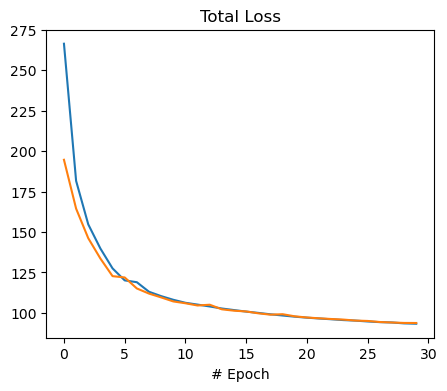

In [75]:
vae = VAE()
trainer = VAETrainer(vae, learning_rate=1e-3, batch_size=128, epoch=30, l2=1e-5)
# train
trainer.train(train_data, val_data)

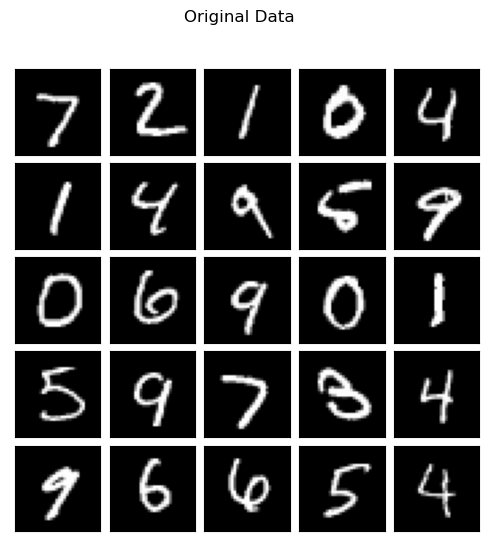

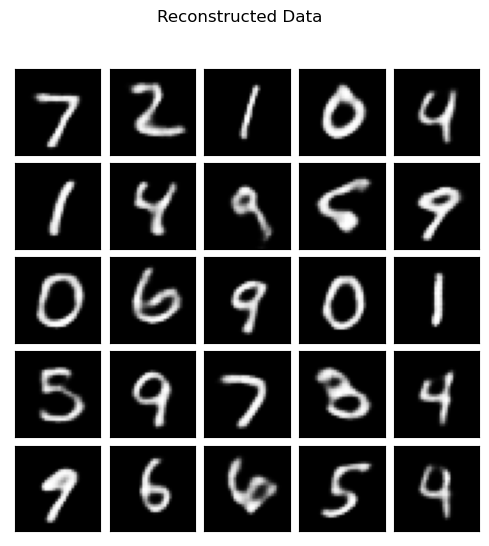

In [77]:
# evaulate the qualitiy of reconstruction
def plot_digits(data, title):
    fig, axes = plt.subplots(5, 5, figsize=(6, 6))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    fig.suptitle(title)
    for i, ax in enumerate(axes.flatten()):
        im = ax.imshow(data[i].reshape(32, 32), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

def compare_reconstruct(model, X):
    plot_digits(X, "Original Data")
    with torch.no_grad():
        X_recon, _, _ = model(X)
    plot_digits(X_recon, "Reconstructed Data")


compare_reconstruct(trainer.model, X_test[:100])

# Question 2

In [76]:
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader as GraphDataLoader
from torch_geometric.utils import scatter

## (a)

In [98]:
def load_qm9(path="./QM9"):
    def transform(data):
        edge_index = torch.tensor(
            list(itertools.permutations(range(data.x.shape[0]), 2)), 
            dtype=torch.long
        ).T
        edge_feature = 1 / torch.sqrt(
            torch.sum(
                (data.pos[edge_index[0]] - data.pos[edge_index[1]]) ** 2, 
                axis=1, keepdim=True
            )
        )
        data.edge_index = edge_index
        data.edge_attr = edge_feature
        data.y = data.y[:, [-7]]
        return data
    
    qm9 = QM9(path, transform=transform)
    return qm9

qm9 = load_qm9("../../Datasets/QM9")
train_data, test_data = train_test_split(qm9, test_size=0.2, random_state=42)

In [86]:
# find out the dimension of node input features
node_input_dim = qm9[0].x.shape[1]
edge_input_dim = 1

## (b)

In [100]:
class Layer(nn.Module):
    """
    Basic layer, a linear layer with a ReLU activation 
    """
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, out_dim), # linear layer
            nn.ReLU() # relu
        )
    
    def forward(self, x):
        return self.layers(x)
    
    
class MessagePassingLayer(nn.Module):
    """
    A message passing layer that updates nodes/edge features
    """
    def __init__(self, node_hidden_dim, edge_hidden_dim):
        super().__init__()
        self.edge_net = Layer(node_hidden_dim * 2 + edge_hidden_dim, edge_hidden_dim)
        self.node_net = Layer(edge_hidden_dim + node_hidden_dim, node_hidden_dim)
    
    def forward(self, node_features, edge_features, edge_index):
        """
        Update node and edge features
        
        Parameters
        ----------
        node_features: torch.Tensor
            Node features from the previous layer
        edge_features: torch.Tensor
            Edge features from the previous layer
        edge_index: torch.Tensor
            A sparse matrix (n_edge, 2) in which each column denotes node indices forming an edge
        """
        # concatnate previous edge features with node features forming the edge
        # hint: use node_features[edge_index[0(or 1)]] to get node features forming the edge
        concate_edge_features = torch.cat([
            node_features[edge_index[0]], # features of one node
            node_features[edge_index[1]], # features of the other node
            edge_features # previous edge features
        ], dim=1)
        
        # pass through the "edge_net" to map it back to the original dimension
        updated_edge_features = self.edge_net(concate_edge_features)
        
        
        # use scatter to aggrate the edge features to nodes
        aggr_edge_features = scatter(updated_edge_features, edge_index[0])
        # concatenate it with previous node features
        concate_node_features = torch.cat([aggr_edge_features, node_features], dim=1)
        # pass through the "node_net" to map it back to the original dimension
        updated_node_features = self.node_net(concate_node_features)
        
        return updated_node_features, updated_edge_features

        
class GraphNet(nn.Module):
    def __init__(self, node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim):
        super().__init__()
        # embed the input node features
        self.node_embed = Layer(node_input_dim, node_hidden_dim)
        # embed the input edge features
        self.edge_embed = Layer(edge_input_dim, edge_hidden_dim)
        # message passing layer
        self.message_passing = MessagePassingLayer(node_hidden_dim, edge_hidden_dim) 
        # Adjust the readout layer input size to match the output size of the message passing layer
        self.readout = nn.Linear(node_hidden_dim, 1)
    
    def forward(self, node_features, edge_features, edge_index, batch):
        """
        Update node and edge features
        
        Parameters
        ----------
        node_features: torch.Tensor
            Node features from the previous layer
        edge_features: torch.Tensor
            Edge features from the previous layer
        edge_index: torch.Tensor
            A sparse matrix (n_edges, 2) in which each column denotes node indices forming an edge
        batch: torch.Tensor
            A 1-D tensor (n_nodes,) that tells you each node belongs to which graph
        """
        node_hidden = self.node_embed(node_features) # call the node embedding
        edge_hidden = self.edge_embed(edge_features) # call the edge embedding
        updated_node_hidden, updated_edge_hidden = self.message_passing(
            node_hidden,
            edge_hidden,
            edge_index) # call the message passing layer
        readout = self.readout(updated_node_hidden) # use the readout layer to output "atomic" contributions
        out = scatter(readout, batch) # use the scatter function to aggregate atomic readouts
        return out

        

In [89]:
class GNNTrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
    
    def train(self, dataset, draw_curve=True):
        self.model.train()
        loader = GraphDataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        loss_func = nn.MSELoss()
        batch_loss_list = []
        for i in range(self.epoch):
            print(f"Epoch: {i}")
            for batch_data in tqdm(loader, leave=False):
                batch_size = batch_data.y.shape[0]
                batch_pred = self.model(
                    batch_data.x, batch_data.edge_attr, 
                    batch_data.edge_index, batch_data.batch
                )
                batch_loss = loss_func(batch_data.y, batch_pred)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                batch_loss_list.append(batch_loss.detach().numpy())
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            ax.plot(np.arange(len(batch_loss_list)), batch_loss_list)
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
        
        return batch_loss_list
    
    def evaluate(self, dataset, draw_curve=True):
        self.model.eval()
        loader = GraphDataLoader(dataset, batch_size=self.batch_size)
        y_true, y_pred = [], []
        with torch.no_grad():
            for batch_data in tqdm(loader, leave=False):
                batch_pred = self.model(
                    batch_data.x, 
                    batch_data.edge_attr, 
                    batch_data.edge_index, 
                    batch_data.batch
                )
                y_pred.append(batch_pred.detach().numpy().flatten())
                y_true.append(batch_data.y.detach().numpy().flatten())
        
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        mse = np.mean((y_true - y_pred) ** 2)
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(y_true, y_pred, label=f"MSE: {mse:.2f}", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            
        return mse
        

## (c)

In [102]:
node_hidden_dim = 64
edge_hidden_dim = 64

net = GraphNet(node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim)

GraphNet - Number of parameters: 21569
Epoch: 0


Epoch: 1


Epoch: 2


[array(7179.5913, dtype=float32),
 array(7145.4707, dtype=float32),
 array(7152.357, dtype=float32),
 array(7185.499, dtype=float32),
 array(7107.1074, dtype=float32),
 array(7194.4756, dtype=float32),
 array(6979.803, dtype=float32),
 array(7026.026, dtype=float32),
 array(6945.817, dtype=float32),
 array(6923.875, dtype=float32),
 array(6962.5186, dtype=float32),
 array(7005.322, dtype=float32),
 array(6860.254, dtype=float32),
 array(6958.962, dtype=float32),
 array(7005.719, dtype=float32),
 array(6642.942, dtype=float32),
 array(6716.4395, dtype=float32),
 array(6790.2793, dtype=float32),
 array(6768.29, dtype=float32),
 array(6661.963, dtype=float32),
 array(6632.952, dtype=float32),
 array(6731.9907, dtype=float32),
 array(6640.645, dtype=float32),
 array(6543.1953, dtype=float32),
 array(6472.2153, dtype=float32),
 array(6512.041, dtype=float32),
 array(6583.3315, dtype=float32),
 array(6478.1274, dtype=float32),
 array(6334.9346, dtype=float32),
 array(6268.2007, dtype=float32

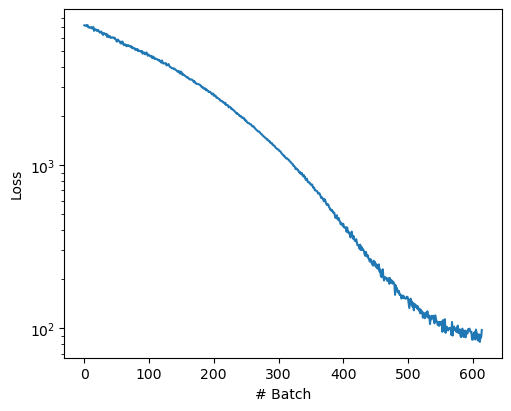

In [103]:
# train
l2 = 1e-5
learning_rate = 1e-3
n_epoch = 3
batch_size = 512

trainer = GNNTrainer(net,batch_size, learning_rate, n_epoch, l2)
trainer.train(train_data)

88.78627

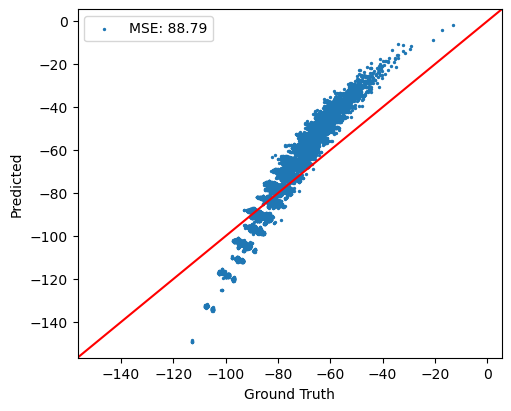

In [104]:
# evaulate
trainer.evaluate(test_data)

it seems the set of data points aligns with the diagonal line, indicating good prediction.